# Serotonin 3D GNN


---

## Setup


### Configuration & Google Drive/Colab Sync

Make sure to adapt the paths if needed.


In [1]:
from pathlib import Path

try:
    from google.colab import drive

    drive.mount("/content/drive")
    IN_COLAB = True
except:
    IN_COLAB = False

print(f"{'Running in Colab' if IN_COLAB else 'Running locally'}")

PATH_NOTEBOOK = (
    Path("/content/drive/MyDrive/Colab Notebooks/serotonin-3d-gnn.ipynb")
    if IN_COLAB
    else Path(
        "/Users/paul/Library/CloudStorage/GoogleDrive-unoutsch@gmail.com/My Drive/Colab Notebooks/serotonin-3d-gnn.ipynb"
    )
)
PATH_REPO = (
    Path("/content/drive/MyDrive/Repositories/serotonin-3d-gnn")
    if IN_COLAB
    else Path.cwd()
)
PATH_DATA = PATH_REPO / "data"
PATH_WEIGHTS = PATH_REPO / "weights"

Running locally


### Installing Requirements


In [3]:
%pip install --requirement "$PATH_REPO/requirements.txt"

Note: you may need to restart the kernel to use updated packages.


### Imports


In [2]:
import os
import sys
import time
import json
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from rdkit import Chem
from rdkit.Chem import AllChem, rdchem, Descriptors, rdMolDescriptors, rdMolTransforms
import seaborn as sns
import shutil
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

### Syncing this file between Colab and local Git repo


In [24]:
def copy_notebook():
    if IN_COLAB:
        shutil.copyfile(PATH_NOTEBOOK, PATH_REPO / "serotonin-3d-gnn.ipynb")
        print("Copied notebook to repo.")
    else:
        shutil.copyfile(PATH_REPO / "serotonin-3d-gnn.ipynb", PATH_NOTEBOOK)
        print("Copied notebook to Google Drive.")


copy_notebook()

Copied notebook to Google Drive.


### Setting Torch Device


In [3]:
if torch.cuda.is_available():
    print("Using CUDA")
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    print("Using MPS")
    device = torch.device("mps")
else:
    print("Using CPU")
    device = torch.device("cpu")

Using MPS


---

## Data Preprocessing

Data collected from ChEMBL 35 database: https://ftp.ebi.ac.uk/pub/databases/chembl/ChEMBLdb/releases/chembl_35/

I used the ChEMBL web interface to download the data.

I filtered the data as follows:

-   selected a subset of serotonin single protein targets of homo sapiens (the ones with relatively many available activity records)
-   filtered activity records of those targets as follows:
    -   must contain pchembl binding affinity value of Ki $(-log_{10}(Ki))$
    -   must not be N/A records
    -   must be cell-based records (working with functional response in living cells, which may be more noisy but also more relevant for application purposes)
-   Note: very low pchembl values get assigned "not active"


### Loading and Preprocessing Serotonin Data


In [4]:
csv_files = glob(os.path.join(PATH_DATA / "targets" / "*.csv"))
print(csv_files)

data_list = []

for file in csv_files:
    df = pd.read_csv(
        file, delimiter=";", usecols=["Smiles", "pChEMBL Value", "Target Name"]
    )
    df.columns = ["smiles", "pchembl_value", "target_name"]
    data_list.append(df)

merged_df = pd.concat(data_list, ignore_index=True)
print(f"Total number of data points: {len(merged_df)}")
print(merged_df.head())

merged_df["target_name"] = merged_df["target_name"].astype("category")
merged_df["target_id"] = merged_df["target_name"].cat.codes

target_name_to_id = dict(
    zip(
        merged_df["target_name"].cat.categories,
        range(len(merged_df["target_name"].cat.categories)),
    )
)
target_id_to_name = {v: k for k, v in target_name_to_id.items()}

merged_df.to_csv(os.path.join(PATH_DATA, "merged_serotonin_data.csv"), index=False)

merged_df.describe()

['/Users/paul/My Drive/Repositories/serotonin-3d-gnn/data/targets/serotonin_6_2799.csv', '/Users/paul/My Drive/Repositories/serotonin-3d-gnn/data/targets/serotonin_1d_481.csv', '/Users/paul/My Drive/Repositories/serotonin-3d-gnn/data/targets/serotonin_4_338.csv', '/Users/paul/My Drive/Repositories/serotonin-3d-gnn/data/targets/serotonin_7_2317.csv', '/Users/paul/My Drive/Repositories/serotonin-3d-gnn/data/targets/serotonin_1b_466.csv', '/Users/paul/My Drive/Repositories/serotonin-3d-gnn/data/targets/serotonin_2b_833.csv', '/Users/paul/My Drive/Repositories/serotonin-3d-gnn/data/targets/serotonin_1a_3086.csv', '/Users/paul/My Drive/Repositories/serotonin-3d-gnn/data/targets/serotonin_2a_2353.csv', '/Users/paul/My Drive/Repositories/serotonin-3d-gnn/data/targets/serotonin_2c_1385.csv']
Total number of data points: 14058
                                              smiles  pchembl_value  \
0            CCN/C(=N\S(=O)(=O)c1ccccc1)N1CC(CC)C=N1           7.47   
1  Cc1c(S(=O)(=O)NCCCN2CCN(c

,pchembl_value,target_id
count,14058.000000,14058.000000
mean,7.319273,4.189856
std,1.167407,2.950111
min,4.000000,0.000000
25%,6.470000,1.000000
50%,7.300000,4.000000
75%,8.150000,7.000000
max,10.850000,8.000000


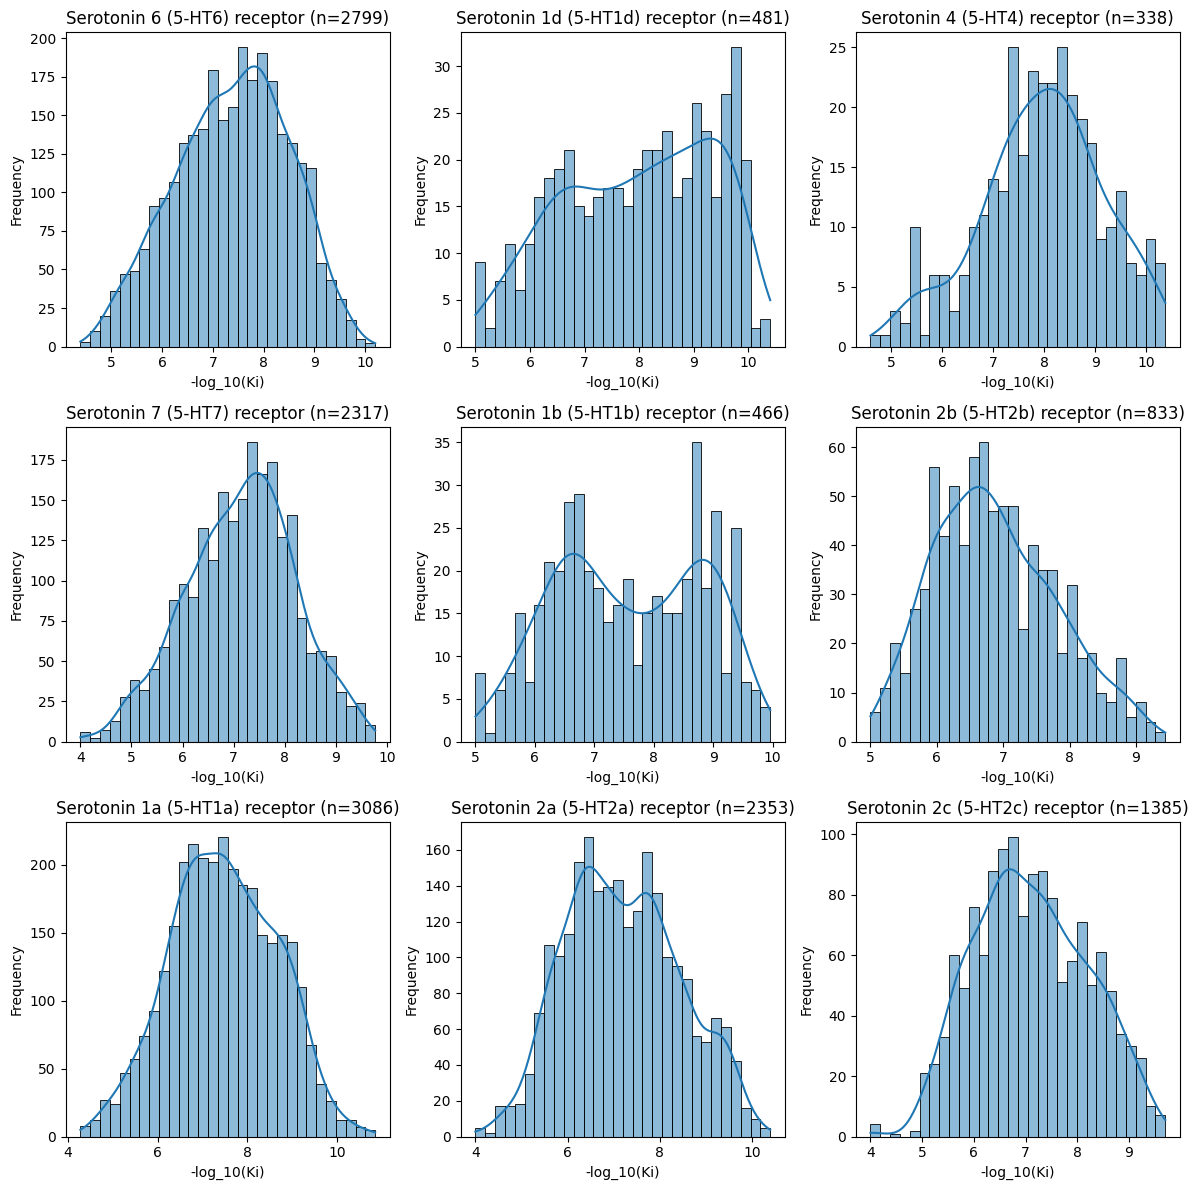

In [5]:
rows, cols = 3, 3
num_targets = merged_df["target_name"].nunique()
target_names = merged_df["target_name"].unique()

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 12))

axes = axes.flatten()

for i, target in enumerate(target_names):
    target_data = merged_df[merged_df["target_name"] == target]["pchembl_value"]
    target_count = merged_df["target_name"].value_counts()[target]

    sns.histplot(target_data, kde=True, bins=30, ax=axes[i])

    axes[i].set_title(f"{target} (n={target_count})")
    axes[i].set_xlabel("-log_10(Ki)")
    axes[i].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

In [6]:
pickle_file_path = os.path.join(PATH_DATA, "merged_serotonin_data_processed.pkl")

if os.path.exists(pickle_file_path):
    print("Loading processed data...")
    with open(pickle_file_path, "rb") as f:
        merged_serotonin_data_processed = pickle.load(f)
    print("Done")
else:
    merged_serotonin_data_processed = None
    print("Will have to create new processed data.")

Loading processed data...
Done


### Creating 3D Molecular Graph Data from Serotonin Data


In [7]:
periodic_table = rdchem.GetPeriodicTable()

ATOM_PROPERTIES = {
    atomic_num: [
        periodic_table.GetAtomicWeight(atomic_num),
        periodic_table.GetRvdw(atomic_num),
        periodic_table.GetDefaultValence(atomic_num),
    ]
    for atomic_num in range(1, 119)  # all elements in periodic table
}

BOND_TYPES = [
    Chem.rdchem.BondType.SINGLE,
    Chem.rdchem.BondType.AROMATIC,
    Chem.rdchem.BondType.DOUBLE,
    Chem.rdchem.BondType.TRIPLE,
]


def create_torch_data(smiles: str, target_value: torch.Tensor, target_id) -> Data:
    # getting RDKit molecule object
    mol = Chem.MolFromSmiles(smiles)

    if mol is None:
        return None

    # add explicit hydrogen atoms to the molecule (are not included in the SMILES string) so that its 3D structure is complete
    mol = Chem.AddHs(mol)
    Chem.SanitizeMol(mol)

    # EmbedMolecule positions atoms of mol in 3D space stochastically; if it fails (returning -1) return None
    if AllChem.EmbedMolecule(mol, randomSeed=42) == -1:
        return None

    # optimize the 3D structure using Universal Force Field (UFF) to lower mol's energy
    status = AllChem.UFFOptimizeMolecule(mol)
    if status == -1:
        print(f"UFF optimization failed for molecule: {smiles}")
        return None
    AllChem.UFFOptimizeMolecule(mol)

    # conformer contains 3D coordinates for mol's atoms
    conformer = mol.GetConformer()

    # molecule-level features
    mol_features = [
        Descriptors.ExactMolWt(mol),
        Descriptors.MolLogP(mol),
        Descriptors.TPSA(mol),
        rdMolDescriptors.CalcNumAromaticRings(mol),
        rdMolDescriptors.CalcNumBridgeheadAtoms(mol),
        rdMolDescriptors.CalcNumRotatableBonds(mol),
        rdMolDescriptors.CalcNumHBD(mol),
        rdMolDescriptors.CalcNumHBA(mol),
    ]

    # atom-level features and 3D positions
    atom_features, positions = [], []
    for atom in mol.GetAtoms():
        atomic_num = atom.GetAtomicNum()
        atomic_mass, vdw_radius, valence = ATOM_PROPERTIES.get(
            atomic_num, [0.0, 0.0, 0]
        )

        features = [
            atomic_mass,
            vdw_radius,
            valence,
            atom.GetFormalCharge(),
            int(atom.GetIsAromatic()),
            atom.GetDegree(),
            int(atom.IsInRing()),
        ] + [
            1.0 if atom.GetHybridization() == h else 0.0
            for h in (
                Chem.rdchem.HybridizationType.SP,
                Chem.rdchem.HybridizationType.SP2,
                Chem.rdchem.HybridizationType.SP3,
            )
        ]

        atom_features.append(features)

        pos = conformer.GetAtomPosition(atom.GetIdx())
        positions.append([pos.x, pos.y, pos.z])

    # transform to PyTorch tensors
    x = torch.tensor(atom_features, dtype=torch.float)
    pos = torch.tensor(positions, dtype=torch.float)

    # bonds between atoms – indices of connected atoms as well as types and conjugation
    edge_index, edge_attr = [], []
    for bond in mol.GetBonds():
        # indices of bonded atoms
        i, j = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()

        # one-hot encode bond type
        bond_type = bond.GetBondType()
        bond_type_one_hot = [1.0 if bond_type == b else 0.0 for b in BOND_TYPES]

        # is_conjugated = 1.0 if bond.GetIsConjugated() else 0.0
        bond_length = rdMolTransforms.GetBondLength(conformer, i, j)

        bond_feat = bond_type_one_hot + [bond_length]

        # adding bond to both nodes
        edge_index += [[i, j], [j, i]]
        edge_attr += [bond_feat, bond_feat]

    # transform to PyTorch tensors
    # edge_index tensor is transposed to fit torch_geometric's expected shape (2, number_of_edges).
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)
    mol_features = torch.tensor(mol_features, dtype=torch.float).unsqueeze(0)

    # graph as PyTorch Geometric Data object
    # x: atom features, [atomic number, degree, formal charge, hybridization]
    # pos: 3D positions of atoms, [x, y, z]
    # edge_index: connectivity indices between atoms, [[i, j], [j, i]]
    # edge_attr: features per bond, [[bond type, conjugation], [bond type, conjugation]]
    return Data(
        x=x,
        pos=pos,
        edge_index=edge_index,
        edge_attr=edge_attr,
        y=target_value,
        target_id=target_id,
        smiles=smiles,
        mol_features=mol_features,
    )


if not merged_serotonin_data_processed:
    merged_serotonin_data_processed = []
    for i, row in enumerate(merged_df.itertuples()):
        pct_complete = 100 * i / len(merged_df)
        sys.stdout.write(f"\r{pct_complete:.2f}% complete")
        sys.stdout.flush()

        data_obj = create_torch_data(
            row.smiles,
            torch.tensor(row.pchembl_value, dtype=torch.float),
            row.target_id,
        )

        if data_obj:
            merged_serotonin_data_processed.append(data_obj)

    pickle_file_path = PATH_DATA / "merged_serotonin_data_processed.pkl"

    with open(pickle_file_path, "wb") as f:
        pickle.dump(merged_serotonin_data_processed, f)

    print(f"Saved merged_serotonin_data_processed to {pickle_file_path}")

print(f"merged_serotonin_data_processed[0] {merged_serotonin_data_processed[0]}")

merged_serotonin_data_processed[0] Data(x=[41, 10], edge_index=[2, 84], edge_attr=[84, 5], y=7.46999979019165, pos=[41, 3], target_id=7, smiles='CCN/C(=N\S(=O)(=O)c1ccccc1)N1CC(CC)C=N1', mol_features=[1, 8])


### Normalizing Data


In [8]:
import copy
import torch

np.random.seed(42)
np.random.shuffle(merged_serotonin_data_processed)

x_sum, x_sq_sum, x_count = 0, 0, 0
edge_attr_sum, edge_attr_sq_sum, edge_count = 0, 0, 0
mol_features_sum, mol_features_sq_sum, mol_count = 0, 0, 0

pchembl_sum, pchembl_sq_sum, pchembl_count = {}, {}, {}

for d in merged_serotonin_data_processed:
    x_sum += d.x.sum(dim=0)
    x_sq_sum += (d.x**2).sum(dim=0)
    x_count += d.x.shape[0]

    edge_attr_sum += d.edge_attr.sum(dim=0)
    edge_attr_sq_sum += (d.edge_attr**2).sum(dim=0)
    edge_count += d.edge_attr.shape[0]

    mol_features_sum += d.mol_features.sum(dim=0)
    mol_features_sq_sum += (d.mol_features**2).sum(dim=0)
    mol_count += d.mol_features.shape[0]

    target_id = d.target_id
    if target_id not in pchembl_sum:
        pchembl_sum[target_id], pchembl_sq_sum[target_id], pchembl_count[target_id] = (
            0,
            0,
            0,
        )

    pchembl_sum[target_id] += d.y.sum()
    pchembl_sq_sum[target_id] += (d.y**2).sum()
    pchembl_count[target_id] += 1

x_mean = x_sum / x_count
x_std = ((x_sq_sum / x_count) - (x_mean**2)).sqrt()

edge_attr_mean = edge_attr_sum / edge_count
edge_attr_std = ((edge_attr_sq_sum / edge_count) - (edge_attr_mean**2)).sqrt()

mol_features_mean = mol_features_sum / mol_count
mol_features_std = ((mol_features_sq_sum / mol_count) - (mol_features_mean**2)).sqrt()

pchembl_mean, pchembl_std = {}, {}
for target_id in pchembl_sum.keys():
    pchembl_mean[target_id] = pchembl_sum[target_id] / pchembl_count[target_id]
    pchembl_std[target_id] = torch.sqrt(
        (pchembl_sq_sum[target_id] / pchembl_count[target_id])
        - (pchembl_mean[target_id] ** 2)
    )


def normalize_dataset(dataset):
    normalized_dataset = []

    for d in dataset:
        d_cloned = copy.deepcopy(d)  # no referenceto original
        target_id = d.target_id

        d_cloned.x = (d_cloned.x - x_mean) / x_std
        d_cloned.edge_attr = (d_cloned.edge_attr - edge_attr_mean) / edge_attr_std
        d_cloned.mol_features = (
            d_cloned.mol_features - mol_features_mean
        ) / mol_features_std
        d_cloned.y = (d_cloned.y - pchembl_mean[target_id]) / pchembl_std[target_id]

        normalized_dataset.append(d_cloned)

    return normalized_dataset


merged_serotonin_data_processed_normalized = normalize_dataset(
    merged_serotonin_data_processed
)

print("z-normalization done")
print(
    f"examples normalized target: {[merged_serotonin_data_processed_normalized[i].y for i in range(10)]}"
)
print(
    f"examples original target: {[merged_serotonin_data_processed[i].y for i in range(10)]}"
)

z-normalization done
examples normalized target: [tensor(1.6672), tensor(-2.4334), tensor(-0.2873), tensor(-0.9850), tensor(0.6981), tensor(-1.5366), tensor(0.3267), tensor(-0.9246), tensor(0.9100), tensor(-1.4940)]
examples original target: [tensor(9.9700), tensor(4.4600), tensor(6.8400), tensor(6.3000), tensor(8.3000), tensor(5.6600), tensor(7.4600), tensor(6.1000), tensor(8.7000), tensor(5.3600)]


### Splitting Data

Splitting serotonin data into target / pretraining sets (5-HT2A / other).
Splitting 5-HT2A data into train / test sets.


In [9]:
target_id = target_name_to_id["Serotonin 2a (5-HT2a) receptor"]

merged_serotonin_data_processed_5ht2a = [
    data
    for data in merged_serotonin_data_processed_normalized
    if data.target_id == target_id
]
merged_serotonin_data_processed_pretrain = [
    data
    for data in merged_serotonin_data_processed_normalized
    if data.target_id != target_id
]

print(f"5-HT2a receptor data: {len(merged_serotonin_data_processed_5ht2a)} samples")
print(f"Pretraining data: {len(merged_serotonin_data_processed_pretrain)} samples\n")

split_idx = int(0.9 * len(merged_serotonin_data_processed_5ht2a))

merged_serotonin_data_processed_5ht2a_train = merged_serotonin_data_processed_5ht2a[
    :split_idx
]
merged_serotonin_data_processed_5ht2a_test = merged_serotonin_data_processed_5ht2a[
    split_idx:
]

print(
    f"5-HT2a receptor training data: {len(merged_serotonin_data_processed_5ht2a_train)} samples"
)
print(
    f"5-HT2a receptor test data: {len(merged_serotonin_data_processed_5ht2a_test)} samples\n"
)

print(f"Example 5-HT2a data object: {merged_serotonin_data_processed_5ht2a_train[0]}")
print(
    f"Example pretraining data object: {merged_serotonin_data_processed_pretrain[0]}\n"
)

y_train = [
    d.y.cpu().numpy()
    for d in merged_serotonin_data_processed_5ht2a_train
    if d.y.numel() > 0
]
sigma_train = np.nanstd(y_train)

print(
    "Standard deviation of z-normalized -log_10(Ki) in 5-HT2a train set:", sigma_train
)

5-HT2a receptor data: 2351 samples
Pretraining data: 11702 samples

5-HT2a receptor training data: 2115 samples
5-HT2a receptor test data: 236 samples

Example 5-HT2a data object: Data(x=[54, 10], edge_index=[2, 112], edge_attr=[112, 5], y=-1.4940271377563477, pos=[54, 3], target_id=3, smiles='Nc1nc(N)nc(NCCCCCN2CCN(c3ccccc3)CC2)n1', mol_features=[1, 8])
Example pretraining data object: Data(x=[67, 10], edge_index=[2, 140], edge_attr=[140, 5], y=1.6671613454818726, pos=[67, 3], target_id=6, smiles='COC(=O)CCCCCN1CCC(CNC(=O)c2c3n(c4ccccc24)CCCO3)CC1', mol_features=[1, 8])

Standard deviation of z-normalized -log_10(Ki) in 5-HT2a train set: 0.9995005


---

## Model Architectures


### Naive Baseline


In [13]:
class MeanBaseline:
    def __init__(self):
        self.mean_ = None

    def fit(self, y):
        self.mean_ = np.nanmean(y)

    def predict(self, n):
        return np.tile(self.mean_, n)

### SeroGCN


In [18]:
from torch_geometric.nn import GCNConv, global_max_pool
from torch.nn import Linear
import torch.nn.functional as F

n_features = merged_serotonin_data_processed_5ht2a_train[0].x.shape[1]


class SeroGCN(torch.nn.Module):
    def __init__(self, n_hidden, n_out=1):
        super(SeroGCN, self).__init__()

        self.conv1 = GCNConv(n_features, n_hidden)
        self.conv2 = GCNConv(n_hidden, n_hidden)
        self.fc = Linear(n_hidden, n_out)
        self.sigma = 1.0  # distance weighting parameter

    def forward(self, mol_batch) -> torch.Tensor:
        x, pos, edge_index = (
            mol_batch.x,
            mol_batch.pos,
            mol_batch.edge_index,
        )

        row, col = edge_index
        eucl_edge_dist = torch.norm(pos[row] - pos[col], p=2, dim=1)
        weight_distance = torch.exp(
            -(eucl_edge_dist**2) / (2 * self.sigma**2)
        )  # Gaussian distance weighting

        # message passing with diustance weights
        x = self.conv1(x, edge_index, edge_weight=weight_distance)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)

        # global pooling for graph-level representation
        x = global_max_pool(x, mol_batch.batch)
        x = self.fc(x)

        return x

---

## Training Logic


In [19]:
def fit(
    model: torch.nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    optimizer: torch.optim.Optimizer,
    criterion,
    epochs: int,
):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        # --- Training ---
        model.train()
        epoch_loss = 0.0
        start_epoch = time.time()

        for i, data in enumerate(train_loader):
            data = data.to(device)
            optimizer.zero_grad()
            out = model(data)  # (batch_size, n_out)

            batch_size = out.shape[0]
            target_values = data.y.view(batch_size)  # (batch_size)
            # if all data.target_id are 3, make target_indices all 0

            if torch.all(
                data.target_id == 3
            ):  # if all targets are 5-HT2a, set all indices to 0
                target_indices = torch.zeros_like(data.target_id)
            else:
                target_indices = torch.where(
                    data.target_id > 3, data.target_id - 1, data.target_id
                )  # not the nicest approach, but the 5-HT2a receptor unfortunately has target_id 3
            selected_outputs = out[
                torch.arange(batch_size), target_indices
            ]  # (batch_size)

            loss = criterion(selected_outputs, target_values)

            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

            pct_complete = 100 * (i + 1) / len(train_loader)
            sys.stdout.write(
                f"\rEpoch {epoch+1}/{epochs} - {pct_complete:.2f}% complete"
            )
            sys.stdout.flush()

        train_loss_avg = epoch_loss / len(train_loader)

        # --- Validation ---
        model.eval()
        val_epoch_loss = 0.0
        with torch.no_grad():
            for val_data in val_loader:
                val_data = val_data.to(device)
                val_out = model(val_data)

                batch_size = val_out.shape[0]
                val_target_values = val_data.y.view(batch_size)
                if torch.all(val_data.target_id == 3):
                    val_target_indices = torch.zeros_like(val_data.target_id)
                else:
                    val_target_indices = torch.where(
                        val_data.target_id > 3,
                        val_data.target_id - 1,
                        val_data.target_id,
                    )  # again – I know – not the nicest approach
                val_selected_outputs = val_out[
                    torch.arange(batch_size), val_target_indices
                ]

                val_loss = criterion(val_selected_outputs, val_target_values)

                val_epoch_loss += val_loss.item()
        val_loss_avg = val_epoch_loss / len(val_loader)
        end_epoch = time.time()

        print(
            f"\nEpoch {epoch+1} completed. Train Loss = {train_loss_avg:.4f} | Val Loss = {val_loss_avg:.4f}. Time taken: {end_epoch - start_epoch:.2f}s"
        )
        train_losses.append(train_loss_avg)
        val_losses.append(val_loss_avg)

    return train_losses, val_losses

In [20]:
import copy

from sklearn.model_selection import KFold
from torch.utils.data import Subset
from torch_geometric.loader import DataLoader
import torch


def k_fold_cv(
    initialized_model,
    Optimizer,
    criterion,
    dataset,
    k=5,
    epochs=10,
    batch_size=32,
    lr=0.01,
    fit_final_model=False,
):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    fold_train_losses = []
    fold_val_losses = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
        print(f"\n--- Fold {fold+1}/{k} ---")

        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

        model_tmp = copy.deepcopy(initialized_model)
        optimizer_tmp = Optimizer(model_tmp.parameters(), lr=lr, weight_decay=1e-4)

        train_losses, val_losses = fit(
            model_tmp, train_loader, val_loader, optimizer_tmp, criterion, epochs
        )

        fold_train_losses.append(train_losses)
        fold_val_losses.append(val_losses)

        print(
            f"Fold {fold+1} completed. Final train loss: {train_losses[-1]:.4f} | Final val loss: {val_losses[-1]:.4f}"
        )

    print("\n--- K-Fold CV completed ---")
    print(
        f"Average final train loss: {sum([l[-1] for l in fold_train_losses]) / k:.4f}"
    )
    print(f"Average final val loss: {sum([l[-1] for l in fold_val_losses]) / k:.4f}")

    if fit_final_model:
        print("\nFitting final model on entire dataset")
        optimizer_final = Optimizer(
            initialized_model.parameters(), lr=lr, weight_decay=1e-4
        )
        data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        fit(
            initialized_model,
            data_loader,
            data_loader,
            optimizer_final,
            criterion,
            epochs,
        )

    return fold_train_losses, fold_val_losses

In [21]:
from itertools import product
from sklearn.model_selection import KFold
from torch.utils.data import Subset


def nested_cv(
    Model,
    n_out,
    Optimizer,
    criterion,
    hyperparam_grid,
    dataset,
    k_outer=5,
    k_inner=5,
):
    # list of one dict per parameter combination
    param_combinations = [
        dict(zip(hyperparam_grid.keys(), values))
        for values in product(*hyperparam_grid.values())
    ]
    n_combinations = len(param_combinations)

    # risk estimate for each outer fold and each hyperparam combo
    R_ests = np.zeros((k_outer, n_combinations))

    if k_outer > 1:
        outer_kf = KFold(n_splits=k_outer, shuffle=True, random_state=42)
    else:  # for compute reasons

        class DummyKFold:
            def split(self, X):
                yield X, X

        outer_kf = DummyKFold()
    dataset_indices = np.arange(len(dataset))

    for i, (outer_train_idx, outer_val_idx) in enumerate(
        outer_kf.split(dataset_indices)
    ):
        print(f"\n--- Outer Fold {i+1}/{k_outer} ---")

        outer_train_dataset = Subset(dataset, outer_train_idx)
        outer_val_dataset = Subset(dataset, outer_val_idx)

        # per hyperparam combo, perform inner k_fold_cv
        for j, params in enumerate(param_combinations):
            model = Model(params["n_hidden"], n_out).to(device)

            # Run k_fold_cv on the outer training dataset.
            _, fold_val_losses = k_fold_cv(
                initialized_model=model,
                Optimizer=Optimizer,
                criterion=criterion,
                dataset=outer_train_dataset,
                k=k_inner,
                epochs=params["epochs"],
                # batch_size=params["batch_size"],
                batch_size=64,  # hard-coded for compute reasons
                lr=params["lr"],
            )
            # average val risk over inner folds
            final_losses = [losses[-1] for losses in fold_val_losses]
            R_est = np.mean(final_losses)
            R_ests[i, j] = R_est
            print(
                f"Outer fold {i+1}, param set {j+1}/{n_combinations}: Risk = {R_est:.4f}"
            )

    # average risk per hyperparam combination over outer folds
    R_ests_params = np.mean(R_ests, axis=0)
    best_idx = np.argmin(R_ests_params)
    best_params = param_combinations[best_idx]

    print(
        f"\nSelected best hyperparameters (avg risk {R_ests_params[best_idx]:.4f}): {best_params}"
    )

    # train final model on full dataset
    model_final = Model(best_params["n_hidden"], n_out).to(device)
    _, final_val_losses = k_fold_cv(
        initialized_model=model_final,
        Optimizer=Optimizer,
        criterion=criterion,
        dataset=dataset,
        k=k_inner,
        epochs=best_params["epochs"],
        # batch_size=params["batch_size"],
        batch_size=64,  # hard-coded for compute reasons
        lr=best_params["lr"],
        fit_final_model=True,
    )
    final_R_est = np.mean([losses[-1] for losses in final_val_losses])
    print(f"Final model empirical risk estimate on full dataset: {final_R_est:.4f}")

    return model_final, best_params, final_R_est

---

## Training & Model Selection


### Naive Baseline: Average Prediction


In [18]:
split_idx_baseline = int(0.8 * len(merged_serotonin_data_processed_5ht2a_train))

y_train_baseline = [
    d.y.numpy()
    for d in merged_serotonin_data_processed_5ht2a_train[:split_idx_baseline]
]
y_val_baseline = [
    d.y.numpy()
    for d in merged_serotonin_data_processed_5ht2a_train[split_idx_baseline:]
]

naive_baseline = MeanBaseline()
naive_baseline.fit(y_train_baseline)
naive_baseline_predictions = naive_baseline.predict(len(y_val_baseline))

# compute mse
mse = np.nanmean((y_val_baseline - naive_baseline_predictions) ** 2, axis=0)
rmse = np.sqrt(mse)
print(f"Naive baseline RMSE: {rmse}")

Naive baseline RMSE: 1.013871669769287


### Baseline: Random Forest with 2D Descriptors


In [16]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from rdkit.Chem import Descriptors

# tried a bunch of descriptor functions from Descriptors._descList
# – these are the ones that did NOT crash the kernel ...
safe_descriptors = [
    "MolWt",
    "MolLogP",
    "MolMR",
    "NumValenceElectrons",
    "NumRadicalElectrons",
    "HeavyAtomCount",
    "NHOHCount",
    "NOCount",
    "RingCount",
    "FractionCSP3",
    "TPSA",
    "NumHDonors",
    "NumHAcceptors",
    "NumRotatableBonds",
    "HallKierAlpha",
    "Kappa1",
    "Kappa2",
    "Kappa3",
    "Chi0",
    "Chi1",
    "fr_Al_COO",
    "fr_Al_OH",
    "fr_Ar_N",
    "fr_C_O",
    "fr_NH1",
    "fr_NH2",
]

descriptor_functions = {name: getattr(Descriptors, name) for name in safe_descriptors}


# extract a fixed-length feature vector from the graph data, as input to RF model
def compute_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    desc_values = []
    for _, func in descriptor_functions.items():
        try:
            desc_values.append(func(mol))
        except:
            print(f"Error computing descriptor {func}")
    return np.array(desc_values)


X = []
y = []
for data in merged_serotonin_data_processed_5ht2a_train:
    features = compute_descriptors(data.smiles)
    if features is None:
        continue
    mol_features = (
        data.mol_features.cpu().numpy()
        if hasattr(data.mol_features, "cpu")
        else np.array(data.mol_features)
    )
    combined_features = np.concatenate([features, mol_features[0]])
    X.append(features)
    target_val = data.y.cpu().numpy() if data.y.numel() > 0 else np.nan
    y.append(target_val)

X = np.array(X)
y = np.array(y)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_scores = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f"Training Fold {fold + 1}...")

    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)
    rmse_scores.append(rmse)

    print(f"Fold {fold + 1} RMSE: {rmse:.4f}")

# Report average RMSE
avg_rmse = np.mean(rmse_scores)
print(f"\nAverage 5-Fold CV RMSE: {avg_rmse:.4f}")

Training Fold 1...
Fold 1 RMSE: 0.6344
Training Fold 2...
Fold 2 RMSE: 0.6269
Training Fold 3...
Fold 3 RMSE: 0.6337
Training Fold 4...
Fold 4 RMSE: 0.6111
Training Fold 5...
Fold 5 RMSE: 0.6404

Average 5-Fold CV RMSE: 0.6293


### Approach 1: SeroGCN without Pretraining


In [20]:
weights_path = PATH_WEIGHTS / "sero_gcn_final_weights.pth"
params_path = PATH_WEIGHTS / "best_params_sero.json"

if os.path.exists(weights_path) and os.path.exists(params_path):
    print("Loading existing trained model and best hyperparameters...")

    with open(params_path, "r") as f:
        best_params_sero_gcn = json.load(f)["best_params_sero_gcn"]

    sero_gcn_final = SeroGCN(best_params_sero_gcn["n_hidden"]).to(device)

    sero_gcn_final.load_state_dict(
        torch.load(weights_path, map_location=device, weights_only=True)
    )

    print("Done")
else:
    n_out = 1

    hyperparam_grid = {
        "lr": [0.1, 0.01, 0.001],
        "n_hidden": [32, 64, 128],
        "epochs": [10, 20, 30],
    }

    sero_gcn_final, best_params_sero_gcn, final_R_est_sero_gcn = nested_cv(
        SeroGCN,
        n_out,
        torch.optim.Adam,
        torch.nn.MSELoss(),
        hyperparam_grid,
        merged_serotonin_data_processed_5ht2a_train,
        k_outer=1,  # compute reasons
        k_inner=5,
    )

    torch.save(sero_gcn_final.state_dict(), PATH_WEIGHTS / "sero_gcn_final_weights.pth")

    with open(PATH_WEIGHTS / "best_params_sero.json", "w") as f:
        json.dump(
            {
                "best_params_sero_gcn": best_params_sero_gcn,
                "final_R_est_sero_gcn": final_R_est_sero_gcn,
            },
            f,
        )

Loading existing trained model and best hyperparameters...
Done


### Approach 2: SeroGCN with Pretraining


#### Pretraining: Hyperparameter Selection


In [21]:
weights_path = PATH_WEIGHTS / "pretrained_sero_gcn_pretrained_weights.pth"
params_path = PATH_WEIGHTS / "best_params_pretrained_sero.json"
if os.path.exists(weights_path) and os.path.exists(params_path):
    print("Loading existing pretrained model and best hyperparameters...")

    with open(params_path, "r") as f:
        best_params_pretrained_sero_gcn = json.load(f)[
            "best_params_pretrained_sero_gcn"
        ]

    n_out = len(target_name_to_id.values()) - 1

    pretrained_sero_gcn = SeroGCN(
        best_params_pretrained_sero_gcn["n_hidden"], n_out
    ).to(device)

    pretrained_sero_gcn.load_state_dict(
        torch.load(weights_path, map_location=device, weights_only=True)
    )

    print("Done")
else:
    # adapted hyperparams based on performance of previous 5-HT2A model
    hyperparam_grid = {
        "lr": [0.01, 0.005, 0.001],
        "n_hidden": [64],
        "epochs": [
            30,
            40,
        ],
    }

    n_out = len(target_name_to_id.values()) - 1  # excluding 5-HT2A target
    print(f"Number of targets: {n_out}")

    (
        pretrained_sero_gcn,
        best_params_pretrained_sero_gcn,
        final_R_est_pretrained_sero_gcn,
    ) = nested_cv(
        SeroGCN,
        n_out,
        torch.optim.Adam,
        torch.nn.MSELoss(),
        hyperparam_grid,
        merged_serotonin_data_processed_pretrain,
        k_outer=1,  # compute reasons
        k_inner=5,
    )

    torch.save(
        pretrained_sero_gcn.state_dict(),
        PATH_WEIGHTS / "pretrained_sero_gcn_pretrained_weights.pth",
    )

    with open(PATH_WEIGHTS / "best_params_pretrained_sero.json", "w") as f:
        json.dump(
            {
                "best_params_pretrained_sero_gcn": best_params_pretrained_sero_gcn,
                "final_R_est_pretrained_sero_gcn": final_R_est_pretrained_sero_gcn,
            },
            f,
        )

Loading existing pretrained model and best hyperparameters...
Done


#### Finetuning on 5-HT2A Data


In [27]:
weights_path = PATH_WEIGHTS / "pretrained_sero_gcn_final_weights.pth"
params_path = PATH_WEIGHTS / "best_params_pretrained_sero.json"
params_path_pretrained = PATH_WEIGHTS / "pretrained_sero_gcn_pretrained_weights.pth"

if os.path.exists(weights_path) and os.path.exists(params_path):
    print("Loading existing pretrained model and best hyperparameters...")

    with open(params_path, "r") as f:
        best_params_pretrained_sero_gcn = json.load(f)[
            "best_params_pretrained_sero_gcn"
        ]

    pretrained_sero_gcn = SeroGCN(best_params_pretrained_sero_gcn["n_hidden"], 1).to(
        device
    )

    pretrained_sero_gcn.load_state_dict(
        torch.load(weights_path, map_location=device, weights_only=True)
    )

    print("Done")
elif os.path.exists(params_path_pretrained):
    print("Loading pretrained SeroGCN weights from file")
    pretrained_weights = torch.load(
        params_path_pretrained, map_location=device, weights_only=True
    )

    n_out = 1

    sero_gcn_finetune = SeroGCN(best_params_pretrained_sero_gcn["n_hidden"], n_out).to(
        device
    )
    model_dict = sero_gcn_finetune.state_dict()  # including fc layer
    pretrained_weights_filtered = {
        k: v for k, v in pretrained_weights.items() if "fc" not in k
    }  # excluding fc layer
    model_dict.update(pretrained_weights_filtered)  # load pretrained weights

    sero_gcn_finetune.load_state_dict(
        model_dict, strict=False
    )  # allow missing fc weights

    print("Done")

    _, final_val_losses_pretrained_sero_gcn = k_fold_cv(
        initialized_model=sero_gcn_finetune,
        Optimizer=torch.optim.Adam,
        criterion=torch.nn.MSELoss(),
        dataset=merged_serotonin_data_processed_5ht2a_train,
        k=5,
        epochs=best_params_pretrained_sero_gcn["epochs"],
        lr=best_params_pretrained_sero_gcn["lr"]
        * 0.7,  # reduce LR for fine-tuning to prevent overwriting pretrained params
        fit_final_model=True,
    )

    final_losses = [losses[-1] for losses in final_val_losses_pretrained_sero_gcn]
    R_est = np.mean(final_losses)

    torch.save(
        sero_gcn_finetune.state_dict(),
        PATH_WEIGHTS / "pretrained_sero_gcn_final_weights.pth",
    )

    with open(PATH_WEIGHTS / "best_params_pretrained_sero_final.json", "w") as f:
        json.dump(
            {
                "best_params_pretrained_sero_gcn": best_params_pretrained_sero_gcn,
                "final_R_est_pretrained_sero_gcn": R_est,
            },
            f,
        )
else:
    print("No pretrained weights – pretrain first")

Loading existing pretrained model and best hyperparameters...
Done


---

## Test Set Evaluation


### Baseline: Random Forest with 2D Descriptors


In [15]:
X_test = []
y_test = []

for data in merged_serotonin_data_processed_5ht2a_test:
    features = compute_descriptors(data.smiles)
    if features is None:
        continue
    X_test.append(features)
    target_val = data.y.cpu().numpy() if data.y.numel() > 0 else np.nan
    y_test.append(target_val)

X_test = np.array(X_test)
y_test = np.array(y_test)


X_train_rf = []
y_train_rf = []

for data in merged_serotonin_data_processed_5ht2a_train:
    features = compute_descriptors(data.smiles)
    if features is None:
        continue
    X_train_rf.append(features)
    target_val = data.y.cpu().numpy() if data.y.numel() > 0 else np.nan
    y_train_rf.append(target_val)

X_train_rf = np.array(X_train_rf)
y_train_rf = np.array(y_train_rf)

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_rf, y_train_rf)

y_pred_rf = rf.predict(X_test)

mse_rf_test = mean_squared_error(y_test, y_pred_rf)
rmse_rf_test = np.sqrt(mse_rf_test)

print(f"Random Forest Test RMSE: {rmse_rf_test:.4f}")

Random Forest Test RMSE: 0.6100


### Pre-Trained SeroGCN


In [27]:
with open(PATH_WEIGHTS / "best_params_pretrained_sero_final.json", "r") as f:
    best_params_finetuned_sero_gcn = json.load(f)["best_params_pretrained_sero_gcn"]

n_out = 1
sero_gcn_finetune = SeroGCN(best_params_finetuned_sero_gcn["n_hidden"], 1).to(
    device
)

fine_tuned_weights_path = PATH_WEIGHTS / "pretrained_sero_gcn_final_weights.pth"
sero_gcn_finetune.load_state_dict(
    torch.load(fine_tuned_weights_path, map_location=device, weights_only=True)
)

print("Loaded fine-tuned model weights")

sero_gcn_finetune.eval()

test_loader = DataLoader(
    merged_serotonin_data_processed_5ht2a_test, batch_size=32, shuffle=False
)

predictions = []
true_labels = []

with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        out = sero_gcn_finetune(data).squeeze()  # only one target, so squeeze

        predictions.append(out.cpu().numpy())
        true_labels.append(data.y.cpu().numpy())

predictions = np.concatenate(predictions, axis=0)
true_labels = np.concatenate(true_labels, axis=0)

mse = np.mean((predictions - true_labels) ** 2)
print(f"Test RMSE: {np.sqrt(mse):.4f}")

np.save(PATH_WEIGHTS / "sero_gcn_test_predictions.npy", predictions)
print("Saved test predictions.")

Loaded fine-tuned model weights
Test RMSE: 0.6211
Saved test predictions.
